This notebook covers some fundamental ideas in building practical classification models.  The data set comes courtesy of Kaggle (https://www.kaggle.com/dalpozz/creditcardfraud).  The goal is to "accurately" predict cases of fraud based on anonymized banking features.  The essential challenge lies in the fact that the positive class ("fraud class") comprises < 1% of all cases.  One could create a trivial model that predicts no-fraud in every circumstance, and it would thus achieve > 99% accuracy.  Such a model would of course be useless however.  Thus we must take care in how we build and assess the performance of this model.

Below I demonstrate the use of undersampling.  Simply put, I under sample the majority class so that each class has the same number of samples.  This prevents the model for skewing itself toward predicting 0 every time.  I train a logistic regression model which achieves >90% accuracy on the (undersampled) test set.

Undersampling is not necessarily the best way to handle skewed classes, as it violates the common rule of thumb in ML "the more data the better."

Below, I also demonstrate the using a cross-validation set to determine the prediction threshold.

Citation for the data set: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Read in the Data and View.
#Some notes on the features.  They are anonymized from some prior data set, and PCA has been applied
#in order to reduce the dimensionality.  Thus the data is already relatively clean.
#If re-running on your own machine, replace "creditcard.csv" with the local path to your dataset.
df = pd.read_csv("creditcard.csv")
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [3]:
#Check for missing values
n = 0
for col in df.columns:
    n += len(df[pd.isnull(df[col])])
print(n)

0


In [4]:
#Under sample the majority class
pos = df[df['Class']==1]
neg = df[df['Class']==0].sample(n=len(pos))
dat = pos.append(neg)

In [5]:
#Randomly Shuffle the Dataset
d_index = dat.index.tolist()
np.random.shuffle(d_index)
dat = dat.loc[d_index]

In [6]:
#Split Data set into Train, Cross-Validation, and Test Sets according to 60/20/20 rule
#Cross-Validation will be used to pick the threshold value
features = dat.columns[:-1]
train_size = len(dat)//6
cv_size = len(dat)//2
train_X = dat[features].iloc[range(train_size)].as_matrix()
train_y = dat['Class'].iloc[range(train_size)].as_matrix()
cv_X = dat[features].iloc[range(train_size,cv_size+train_size)].as_matrix()
cv_y = dat['Class'].iloc[range(train_size,cv_size+train_size)].as_matrix()
test_X = dat[features].iloc[range(cv_size+train_size,len(dat))].as_matrix()
test_y = dat['Class'].iloc[range(cv_size+train_size,len(dat))].as_matrix()

In [7]:
#Standardize the Features
from sklearn import preprocessing
train_X_scaled = preprocessing.scale(train_X)
cv_X_scaled = preprocessing.scale(cv_X)
test_X_scaled = preprocessing.scale(test_X)

In [8]:
#Train a logistic regression model
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(train_X_scaled, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [9]:
#Assess the Accuracy on cross validation set for multiple threshold values.  Pick the value with the best accuracy.
l = np.arange(0,1,.05)
probs = LR.predict_proba(cv_X_scaled).transpose()[1]
acc = []
for t_val in l:
    predict = np.array( (probs - t_val)>0, dtype = int )
    n_errors = sum( (cv_y - predict)**2 )
    acc.append(1-n_errors/cv_size)

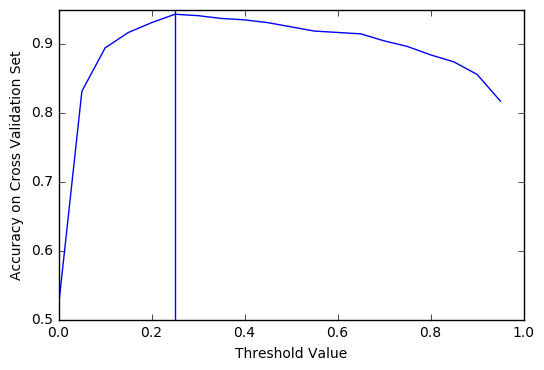

In [10]:
arg_max = 0
for i in range(len(acc)):
    if acc[i]>acc[arg_max]:
        arg_max = i
plt.plot(l,acc)
plt.axvline(x=arg_max*0.05)
plt.xlabel("Threshold Value")
plt.ylabel("Accuracy on Cross Validation Set")

In [11]:
#Assess the Accuracy on the Test Set
probs = LR.predict_proba(test_X_scaled).transpose()[1]
predict = np.array( (probs - l[arg_max])>0, dtype=int)
n_errors = sum( (test_y - predict)**2 )
print("Accuracy over the Test Set")
print( 1 - n_errors/(len(dat) - train_size - cv_size) )

Accuracy over the Test Set
0.926829268293
